# Computer Vision Assignment 1 Part 1
---

Semester: **Fall 2023**

Due date: **October 5th 2023, 11.59PM EST.**

## Introduction
---

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used:
- MNIST (handwritten digits)
- CIFAR-10 (32x32 resolution color images of 10 object classes)

## Instructions
---

You should perform this assignment using Google Colab.
* Before starting, clone this assignment using `File > Save a copy in Drive`.
* After you're done, go through the notebook and ensure that you have answered all questions.
* Finally, submit the ipynb `File > Download > Download .ipynb` on brightspace


## 1. Warmup [5%]
---

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand. MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. On the other hand, CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). The train/test split is 50k/10k.

* (a) Display 10 random images from each class of MNIST
* (b) Do the same for each class of CIFAR-10

Use `matplotlib` and ipython notebook's visualization capabilities. See [this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for hints on how to achieve this.

## 2. Training a Single Layer Network on MNIST [10%]
---

* (a) Start by running the training on MNIST and train the model for 20 epochs.
By default, the model will train on MNIST.

This will initialize a single layer model and train it on the 60,000 MNIST training images for 1 epoch (passes through the training data). The loss function ([cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy)) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. The default values for the learning rate, batch size and number of epochs are given in the `options` cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. Note the decrease in training loss and corresponding decrease in validation errors.

* (b): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

* (c): Reduce the number of training examples to just 50. (Hint: limit the iterator in the `train` function) and train the model until the loss converges. Explain what is happening to the model.

## 3. Training a Multi-Layer Network on MNIST [10%]
---

* (a) Add an extra layer with 1000 hidden units and a `tanh` nonlinearity. (Hint: modify the `Net` class). Train the model for 10 epochs.
* (b) Now set the learning rate to 10 and observe what happens during training. Give a brief explanation of your observations

## 4. Training a Convolutional Network on CIFAR [25%]
---

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- (a) Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

* (b) Train it for 20 epochs on the CIFAR-10 training set. Show an image of the first layer filters.

* (c) Give a breakdown of the parameters within the above model, and the overall number.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist). Also, you may speed up training if you use a GPU runtime (`RunTime > Change Runtime Type > GPU`).

In [4]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import torchsummary


## 1.WARMUP - DATA INSPECTION [5%]

In [5]:
# Function to show images in a grid
def imshow_grid(images, title,mean=0.5, std=0.5):
    images = torchvision.utils.make_grid(images, nrow=10)
    images = images * std + mean    # unnormalize
    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title(title)
    plt.show()

# Display 10 random images for each class
def show_random_images(train_loader,classes,mean,std):
  for i in range(10):
      class_images = []
      for images, labels in train_loader:
          class_images.extend(images[labels == i])
          if len(class_images) >= 10:
              break
      imshow_grid(class_images[:10], f'Class {classes[i]}',mean,std)


In [6]:
#Load Data
mnist_trainset = datasets.MNIST(root='.', train=True, download=True, transform= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))
cifar_trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True, num_workers=0)
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True, num_workers=0)


Files already downloaded and verified


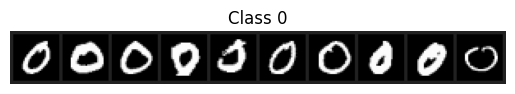

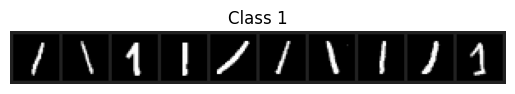

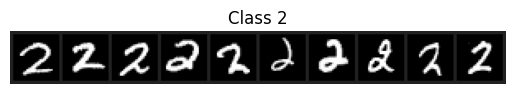

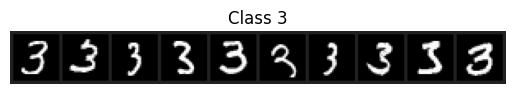

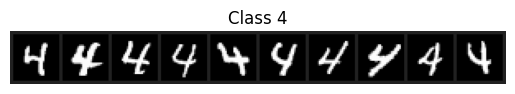

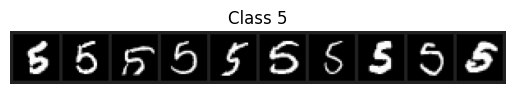

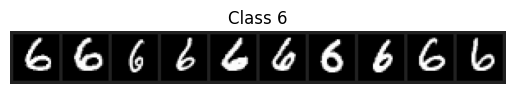

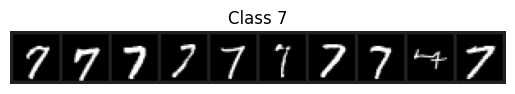

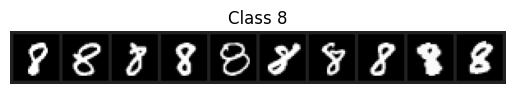

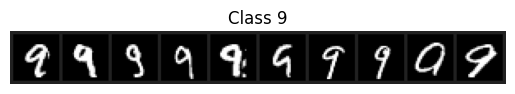

In [7]:
# Display 10 random images for each class of MNIST Dataset
mnist_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
show_random_images(mnist_train_loader,mnist_classes,0.1307,0.3081)


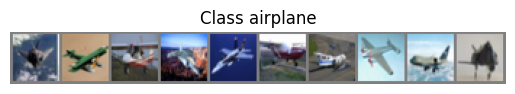

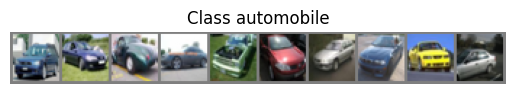

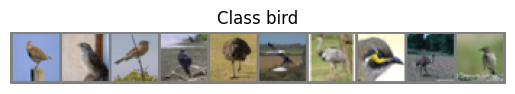

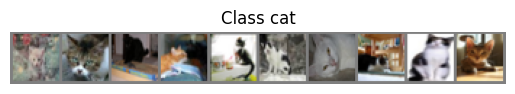

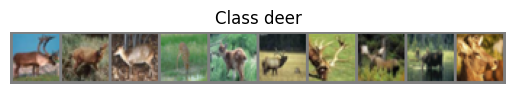

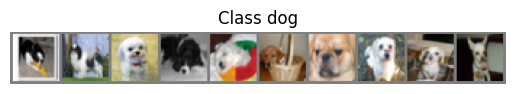

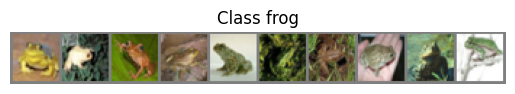

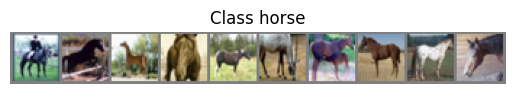

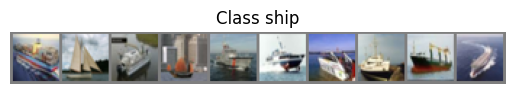

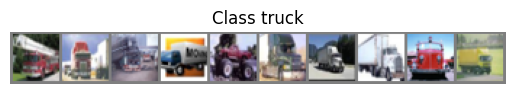

In [8]:
# Display 10 images from each class of CIFAR-10
cifar_classes=('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')
show_random_images(cifar_train_loader,cifar_classes,0.5,0.5)

## 2.TRAINING A SINGLE LAYER NETWORK ON MNIST [10%]

In [9]:
# Options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01         # learning rate

In [10]:
# Data Loading
# This cell might take some time when you run it for the first time,
# because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network.to(device)

Net(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data,target=data.to(device),target.to(device)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [10]:
train(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.412660
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.685290
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.561240
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.410529
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.349345
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.347891
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.378196
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.402445
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.417724
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.416455


In [ ]:
test()


Test set: Average loss: 0.3330, Accuracy: 9092/10000 (91%)



#### 2(a) Train for 20 epochs

In [13]:
num_of_epochs=20
for i in range(0,num_of_epochs):
  train(i)
test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.359844
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.784476
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.325141
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.416802
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.256288
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.455410
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.352072
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.427325
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.267033
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.284064
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.233953
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.200165
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.207544
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.329783
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.327359
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.238541
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.438560
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.329233
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.337886
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.308272
Train Epoch:

#### 2(b) Plot Network weights

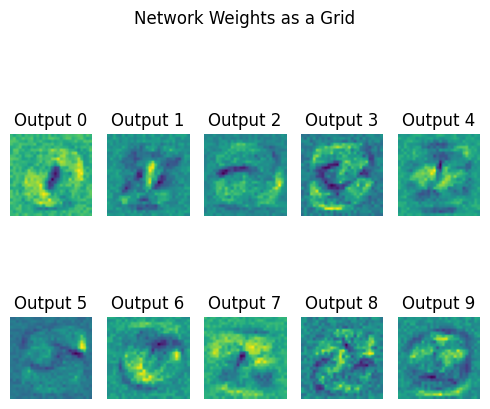

In [14]:
weights = network.linear.weight.data.view(10, 1, 28, 28)
plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(weights[i][0].numpy(), cmap='viridis')
  plt.title(f'Output {i}')
  plt.axis('off')

plt.suptitle('Network Weights as a Grid')
plt.tight_layout()
plt.show()

#### 2(c) Reduce training Examples

In [15]:
num_training_examples=50
reduced_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=0, sampler=torch.utils.data.SubsetRandomSampler(range(num_training_examples)))
network50 = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network50.parameters(), lr=lr)
network50.to(device)

Net(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [16]:
def converge_train(epochs):
  for epoch in range(0,epochs):
      network50.train()
      for batch_idx, (data, target) in enumerate(reduced_train_loader):
          data,target=data.to(device),target.to(target)
          optimizer.zero_grad()
          output = network50(data)
          loss = F.cross_entropy(output, target)
          loss.backward()
          optimizer.step()
      print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
      if epoch > 0 and abs(loss.item() - prev_loss) < 0.0001:
          print("Converged. Stopping training.")
          break
      prev_loss = loss.item()

def converge_test():
    network50.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data,target=data.to(device),target.to(device)
        output = network50(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [17]:
converge_train(350)
converge_test()

Epoch 1, Loss: 2.469665288925171
Epoch 2, Loss: 2.215756893157959
Epoch 3, Loss: 2.0142903327941895
Epoch 4, Loss: 1.846768856048584
Epoch 5, Loss: 1.7033779621124268
Epoch 6, Loss: 1.5779328346252441
Epoch 7, Loss: 1.4667004346847534
Epoch 8, Loss: 1.3673077821731567
Epoch 9, Loss: 1.2780544757843018
Epoch 10, Loss: 1.1976025104522705
Epoch 11, Loss: 1.1248456239700317
Epoch 12, Loss: 1.0588493347167969
Epoch 13, Loss: 0.9988158345222473
Epoch 14, Loss: 0.9440598487854004
Epoch 15, Loss: 0.8939887285232544
Epoch 16, Loss: 0.8480889201164246
Epoch 17, Loss: 0.8059133291244507
Epoch 18, Loss: 0.7670710682868958
Epoch 19, Loss: 0.7312196493148804
Epoch 20, Loss: 0.6980578899383545
Epoch 21, Loss: 0.6673205494880676
Epoch 22, Loss: 0.6387731432914734
Epoch 23, Loss: 0.6122082471847534
Epoch 24, Loss: 0.58744215965271
Epoch 25, Loss: 0.5643113851547241
Epoch 26, Loss: 0.5426708459854126
Epoch 27, Loss: 0.5223907232284546
Epoch 28, Loss: 0.5033556222915649
Epoch 29, Loss: 0.4854619204998016

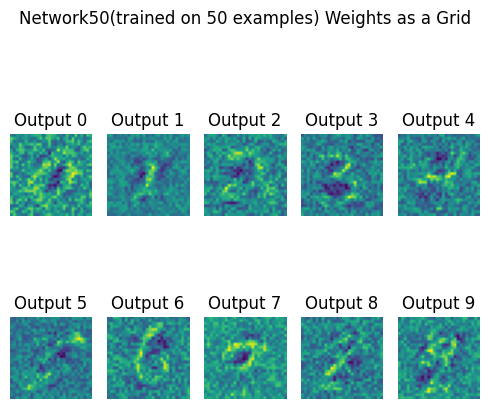

In [18]:
weights = network50.linear.weight.data.view(10, 1, 28, 28)
plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(weights[i][0].numpy(), cmap='viridis')
  plt.title(f'Output {i}')
  plt.axis('off')

plt.suptitle('Network50(trained on 50 examples) Weights as a Grid')
plt.tight_layout()
plt.show()

##### Explaination- We can see that the network weights are very blur and hazy and unstable -> weights are noisy. Since the number of training examples are very less the model is not able to learn the correct weights and instead overfits on the 50 examples before converging

### 3. Training Multilayer Network on MNIST [10%]

#### 3.(a) Add extra layer and train for 10 epochs

In [19]:
#Define new class with extra layer
class Multilayer_Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Multilayer_Net, self).__init__()
        self.linear1 = nn.Linear(num_inputs, 1000)
        self.linear2=nn.Linear(1000,num_outputs)
        self.tanh=nn.Tanh()


    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear1(input)
        output=self.linear2(output)
        output=self.tanh(output)
        return output

def multilayer_train(epoch,mynetwork,myoptimizer,training_loss):
    mynetwork.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)
        myoptimizer.zero_grad()
        output = mynetwork(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        myoptimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    training_loss.append(loss.item())

def multilayer_test(mynetwork):
    mynetwork.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data,target=data.to(device),target.to(device)
        output = mynetwork(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



In [20]:
multilayer_network = Multilayer_Net(num_inputs, num_outputs)
optimizer = optim.SGD(multilayer_network.parameters(), lr=lr)
multilayer_network.to(device)
num_of_epochs=10
multilayer_loss=[]
for epoch in range(0,num_of_epochs):
  multilayer_train(epoch,multilayer_network,optimizer,multilayer_loss)

multilayer_test(multilayer_network)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311161
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.293044
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.120856
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.119442
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.168602
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.021637
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.114695
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.975692
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.055626
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.109842
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.993047
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.020620
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.999915
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.029357
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.094117
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.078061
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.020517
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.015198
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.105037
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.963429
Train Epoch:

#### 3(b) Set learning rate = 10

In [21]:
multilayer_network10 = Multilayer_Net(num_inputs, num_outputs)
optimizer_10 = optim.SGD(multilayer_network10.parameters(), lr=10)
multilayer_network10.to(device)
num_of_epochs=10
multilayer10_loss=[]
for epoch in range(0,num_of_epochs):
  multilayer_train(epoch,multilayer_network10,optimizer_10,multilayer10_loss)

multilayer_test(multilayer_network10)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.275259
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.719206
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.672260
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.792649
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.582414
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.526209
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.445218
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.734782
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.853180
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.594176
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.633499
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.453119
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.649357
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.706180
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.369967
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.834855
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.604515
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.662216
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.672503
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.856140
Train Epoch:

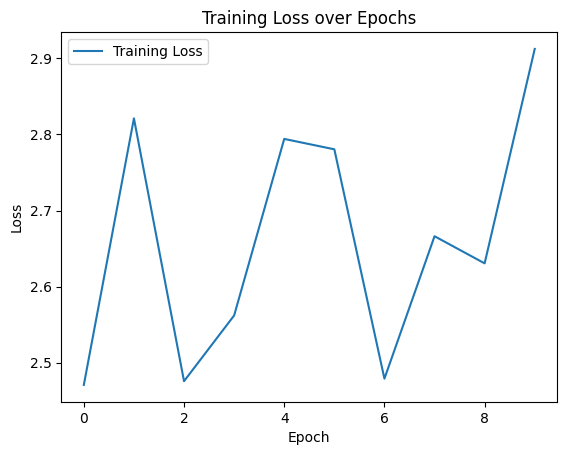

In [22]:
plt.plot(multilayer10_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

##### Explaination- As we can see in the graph, the loss oscilltes a lot. Since the learning rate is too high, it leads to large descents in gradient but we never reach the minima. The correct weights are never leared. Due to osciallting loss, the model has very low accuracy.

### Training a Convolutional Network on CIFAR [25%]

In [23]:
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01

In [24]:
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


#### 4.(a) Build a Convolution NN

In [25]:
class CNN(nn.Module):
  def __init__(self, num_inputs) -> None:
      super().__init__()
      self.layer1=nn.Sequential(nn.Conv2d(3,16,kernel_size=5),
                                nn.Tanh(),
                                nn.MaxPool2d(2,2))
      self.layer2=nn.Sequential(nn.Conv2d(16,128,kernel_size=5),
                                nn.Tanh(),
                                nn.MaxPool2d(2,2))
      self.flatten=nn.Flatten()
      self.fc1=nn.Sequential(nn.Linear(128*5*5,64),nn.Tanh())
      self.fc2=nn.Linear(64,10)

  def forward(self,input):
    input=self.layer1(input)
    input=self.layer2(input)
    input=self.flatten(input)
    input=self.fc1(input)
    input=self.fc2(input)
    return input


def cnn_train(epoch,mynetwork,myoptimizer):
    mynetwork.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)
        myoptimizer.zero_grad()
        output = mynetwork(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        myoptimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def cnn_test(mynetwork):
    mynetwork.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data,target=data.to(device),target.to(device)
        output = mynetwork(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


#### 4(b) Train for 20 epochs


In [26]:
cnn=CNN(num_inputs=3)
cnn.to(device)
optimizer= optim.SGD(cnn.parameters(), lr=lr)
num_of_epochs=20
for epoch in range(0,num_of_epochs):
  cnn_train(epoch,cnn,optimizer)



Train Epoch: 0 [0/50000 (0%)]	Loss: 2.313278
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.141771
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.001377
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.985591
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.796561
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.781105
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.932963
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.782713
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.746586
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.735046
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.834172
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.698861
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.769962
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.635841
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.765977
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.550455
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.576359
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.676030
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.735772
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.674866
Train Epoch: 2 [25

In [27]:
cnn_test(cnn)


Test set: Average loss: 0.9515, Accuracy: 6699/10000 (67%)



#### Images of first layer filters

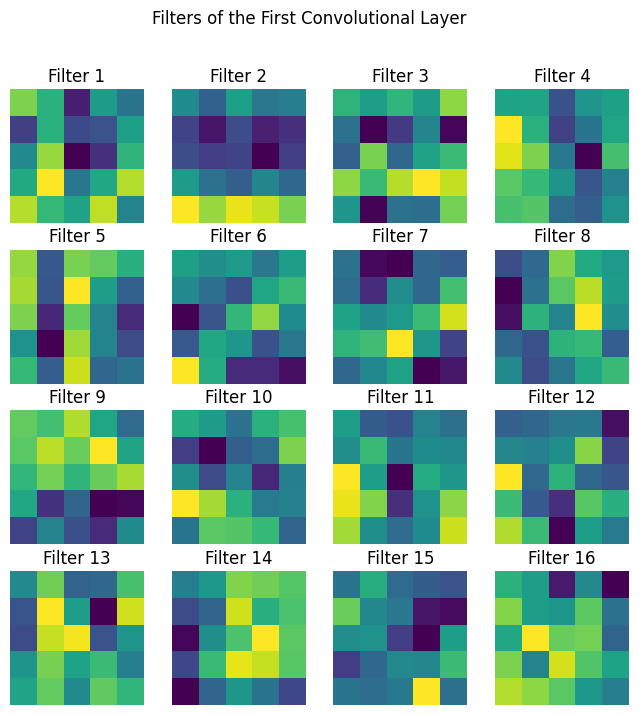

In [28]:
weights = cnn.layer1[0].weight.data
plt.figure(figsize=(8, 8))
for i in range(16):  
    plt.subplot(4, 4, i + 1)
    plt.imshow(weights[i, 0].numpy(), cmap='viridis') 
    plt.title(f'Filter {i + 1}')
    plt.axis('off')

plt.suptitle('Filters of the First Convolutional Layer')
plt.show()

#### 4.(c) Parameter breakdown

In [29]:
from torchsummary import summary
summary(cnn,(3,32,32),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
              Tanh-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4          [-1, 128, 10, 10]          51,328
              Tanh-5          [-1, 128, 10, 10]               0
         MaxPool2d-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                   [-1, 64]         204,864
              Tanh-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 258,058
Trainable params: 258,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.46
Params size (MB): 0.98
Estimated T